IMPORT LIBRARIES & SETUP

In [1]:
# ==============================================
# IMPORT SEMUA LIBRARY
# ==============================================

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

# Preprocessing & Vectorization
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, roc_curve, auc
)

# Sparse matrix handling
from scipy.sparse import hstack

# Save model for deployment
import joblib

# Styling df
pd.set_option("display.max_colwidth", 200)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Random seed for reproducibility
np.random.seed(42)


LOAD & EKSPLORASI DATASET

In [ ]:
# 1. Load dataset
file_path = "data/emails.csv"  
df = pd.read_csv(file_path)

print("Shape dataset:", df.shape)
print("Kolom:", df.columns.tolist())
print("\nInfo dataset:")
df.info()

print("\nMissing value ratio:")
print(df.isna().mean())

print("\nContoh isi kolom 'message':")
df["message"].head(3).values

Shape dataset: (517401, 2)
Kolom: ['file', 'message']

Info dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517401 entries, 0 to 517400
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   file     517401 non-null  object
 1   message  517401 non-null  object
dtypes: object(2)
memory usage: 7.9+ MB

Missing value ratio:
file      0.0000
message   0.0000
dtype: float64

Contoh isi kolom 'message':


array(["Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>\nDate: Mon, 14 May 2001 16:39:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: tim.belden@enron.com\nSubject: \nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: Tim Belden <Tim Belden/Enron@EnronXGate>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-FileName: pallen (Non-Privileged).pst\n\nHere is our forecast\n\n ",
       "Message-ID: <15464986.1075855378456.JavaMail.evans@thyme>\nDate: Fri, 4 May 2001 13:51:00 -0700 (PDT)\nFrom: phillip.allen@enron.com\nTo: john.lavorato@enron.com\nSubject: Re:\nMime-Version: 1.0\nContent-Type: text/plain; charset=us-ascii\nContent-Transfer-Encoding: 7bit\nX-From: Phillip K Allen\nX-To: John J Lavorato <John J Lavorato/ENRON@enronXgate@ENRON>\nX-cc: \nX-bcc: \nX-Folder: \\Phillip_Allen_Jan2002_1\\Allen, Phillip K.\\'Sent Mail\nX-Origin: Allen-P\nX-

PARSING EMAIL (From,To,Subject,Body)

In [4]:
# PARSING EMAIL

def parse_email(raw_text):
    if pd.isna(raw_text):
        return {"from_": "", "to": "", "subject": "", "body": ""}

    text = str(raw_text)
    lines = text.split("\n")

    from_ = ""
    to = ""
    subject = ""
    body_lines = []
    header_ended = False

    for line in lines:
        if not header_ended:
            low = line.lower()
            if low.startswith("from:"):
                from_ = line[5:].strip()
            elif low.startswith("to:"):
                to = line[3:].strip()
            elif low.startswith("subject:"):
                subject = line[8:].strip()

            if line.strip() == "":
                header_ended = True
        else:
            body_lines.append(line)

    body = "\n".join(body_lines).strip()
    return {"from_": from_, "to": to, "subject": subject, "body": body}

parsed = df["message"].apply(parse_email)
parsed_df = pd.DataFrame(list(parsed))

df = pd.concat([df[["file", "message"]], parsed_df], axis=1)

print("Setelah parsing:")
df[["from_", "to", "subject", "body"]].head(3)

Setelah parsing:


,from_,to,subject,body
0,phillip.allen@enron.com,tim.belden@enron.com,,Here is our forecast
1,phillip.allen@enron.com,john.lavorato@enron.com,Re:,Traveling to have a business meeting takes the fun out of the trip. Especially if you have to prepare a presentation. I would suggest holding the business plan meetings here then take a trip wit...
2,phillip.allen@enron.com,leah.arsdall@enron.com,Re: test,test successful. way to go!!!


LABELING SPAM vs HAM (HEURISTIC)

Distribusi kelas:
ham (0)     408976
spam (1)    108425
Name: count, dtype: int64

Proporsi:
ham (0)    0.7904
spam (1)   0.2096
Name: count, dtype: float64


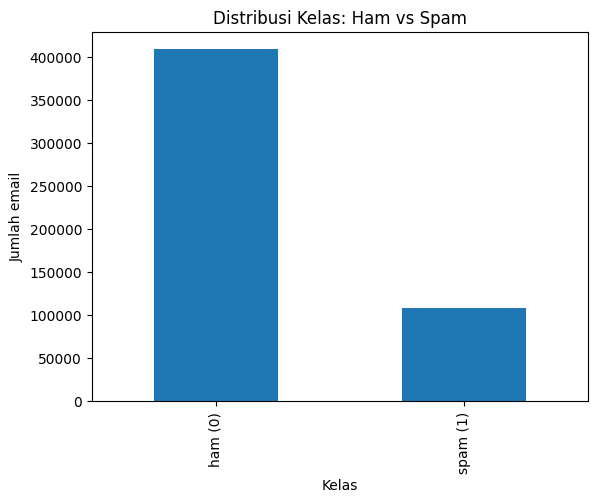

In [5]:
# LABELING SPAM/HAM SECARA HEURISTIC

spam_keywords = [
    "free", "click", "offer", "winner", "prize", "credit card",
    "loan", "unsubscribe", "buy now", "limited time", "act now",
    "earn money", "viagra"
]

def is_spam_email(row):
    text = (str(row["subject"]) + " " + str(row["body"])).lower()
    file_path = str(row["file"]).lower()

    for kw in spam_keywords:
        if kw in text:
            return 1
    if "spam" in file_path or "junk" in file_path:
        return 1
    return 0

df["label"] = df.apply(is_spam_email, axis=1)

print("Distribusi kelas:")
class_counts = df["label"].value_counts().sort_index()
class_counts.index = ["ham (0)", "spam (1)"]
print(class_counts)
print("\nProporsi:")
print(class_counts / class_counts.sum())

plt.figure()
class_counts.plot(kind="bar")
plt.title("Distribusi Kelas: Ham vs Spam")
plt.xlabel("Kelas")
plt.ylabel("Jumlah email")
plt.show()

Distribusi kelas:
ham (0)     408976
spam (1)    108425
Name: count, dtype: int64

Proporsi:
ham (0)    0.7904
spam (1)   0.2096
Name: count, dtype: float64


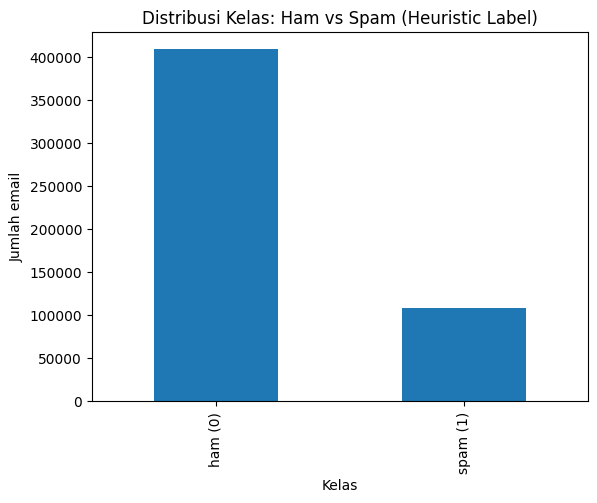


Rata-rata panjang subject & body per kelas:
       subject_len  body_len
label                       
0          25.9412 1067.7633
1          33.1696 4766.0449


In [44]:
# Mengecek distribusi kelas
class_counts = df["label"].value_counts().sort_index()
class_counts.index = ["ham (0)", "spam (1)"]

print("Distribusi kelas:")
print(class_counts)
print("\nProporsi:")
print(class_counts / class_counts.sum())

# Membuat visualisasi 
plt.figure()
class_counts.plot(kind="bar")
plt.title("Distribusi Kelas: Ham vs Spam (Heuristic Label)")
plt.xlabel("Kelas")
plt.ylabel("Jumlah email")
plt.show()

# menghitung panjang subject & body
df["subject_len"] = df["subject"].astype(str).str.len()
df["body_len"] = df["body"].astype(str).str.len()

print("\nRata-rata panjang subject & body per kelas:")
print(df.groupby("label")[["subject_len", "body_len"]].mean())

FEATURE ENGINEERIG (NUMERIC & TEXT)

In [6]:
# Panjang subject & body
df["subject_len"] = df["subject"].astype(str).str.len()
df["body_len"] = df["body"].astype(str).str.len()

# Jumlah URL di body
url_pattern = r"http[s]?://\S+"

def count_urls(text):
    if pd.isna(text):
        return 0
    return len(re.findall(url_pattern, str(text)))

df["num_urls"] = df["body"].apply(count_urls)

# Flag internal sender
df["is_internal_sender"] = df["from_"].str.contains("@enron.com", case=False, na=False).astype(int)

# Gabungkan subject + body jadi satu teks untuk TF-IDF
df["text"] = (df["subject"].fillna("") + " " + df["body"].fillna("")).astype(str)

df[["from_", "subject", "subject_len", "body_len", "num_urls", "is_internal_sender", "label"]].head(5)

,from_,subject,subject_len,body_len,num_urls,is_internal_sender,label
0,phillip.allen@enron.com,,0,20,0,1,0
1,phillip.allen@enron.com,Re:,3,785,0,1,0
2,phillip.allen@enron.com,Re: test,8,30,0,1,0
3,phillip.allen@enron.com,,0,187,0,1,0
4,phillip.allen@enron.com,Re: Hello,9,33,0,1,0


TRAIN-TEST SPLIT

In [7]:
# SPLIT DATASET TRAIN-TEST

X_text = df["text"]
X_num = df[["subject_len", "body_len", "num_urls", "is_internal_sender"]]
y = df["label"]

X_train_text, X_test_text, X_train_num, X_test_num, y_train, y_test = train_test_split(
    X_text, X_num, y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train_text))
print("Test size :", len(X_test_text))
print("\nDistribusi kelas train:")
print(y_train.value_counts(normalize=True))
print("\nDistribusi kelas test:")
print(y_test.value_counts(normalize=True))

Train size: 362180
Test size : 155221

Distribusi kelas train:
label
0   0.7904
1   0.2096
Name: proportion, dtype: float64

Distribusi kelas test:
label
0   0.7904
1   0.2096
Name: proportion, dtype: float64


TF-IDF Feature Extraction

In [9]:
# TF-IDF Vectorization & Gabungkan dengan fitur numerik

tfidf = TfidfVectorizer(
    max_features=50000,
    ngram_range=(1, 2),
    stop_words="english"
)

X_train_tfidf = tfidf.fit_transform(X_train_text)
X_test_tfidf = tfidf.transform(X_test_text)

X_train_all = hstack([X_train_tfidf, X_train_num.values])
X_test_all = hstack([X_test_tfidf, X_test_num.values])

print("Shape X_train_all:", X_train_all.shape)
print("Shape X_test_all :", X_test_all.shape)

Shape X_train_all: (362180, 50004)
Shape X_test_all : (155221, 50004)


MODELING (3 MODEL + BALANCED XGBOOST)

In [10]:
# EVALUATION FUNCTION

def evaluate_model(y_true, y_pred, y_proba, name="model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)

    print(f"=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1-score : {f1:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")
    print()
    print(classification_report(y_true, y_pred, target_names=["ham", "spam"]))
    print("="*40)
    
    return {
        "acc": acc,
        "prec": prec,
        "rec": rec,
        "f1": f1,
        "roc_auc": roc_auc
    }

In [11]:
# --- Logistic Regression ---

logreg = LogisticRegression(max_iter=1200, n_jobs=-1)
logreg.fit(X_train_all, y_train)

y_pred_log = logreg.predict(X_test_all)
y_proba_log = logreg.predict_proba(X_test_all)[:, 1]

metrics_log = evaluate_model(y_test, y_pred_log, y_proba_log, "Logistic Regression")

=== Logistic Regression ===
Accuracy : 0.9429
Precision: 0.9233
Recall   : 0.7933
F1-score : 0.8534
ROC-AUC  : 0.9739

              precision    recall  f1-score   support

         ham       0.95      0.98      0.96    122693
        spam       0.92      0.79      0.85     32528

    accuracy                           0.94    155221
   macro avg       0.94      0.89      0.91    155221
weighted avg       0.94      0.94      0.94    155221



In [12]:
# --- Random Forest ---

rf = RandomForestClassifier(
    n_estimators=150,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train_all, y_train)

y_pred_rf = rf.predict(X_test_all)
y_proba_rf = rf.predict_proba(X_test_all)[:, 1]

metrics_rf = evaluate_model(y_test, y_pred_rf, y_proba_rf, "Random Forest")


=== Random Forest ===
Accuracy : 0.9941
Precision: 0.9930
Recall   : 0.9787
F1-score : 0.9858
ROC-AUC  : 0.9986

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00    122693
        spam       0.99      0.98      0.99     32528

    accuracy                           0.99    155221
   macro avg       0.99      0.99      0.99    155221
weighted avg       0.99      0.99      0.99    155221



In [13]:
# --- XGBoost ---

xgb_base = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    n_jobs=-1,
    random_state=42,
    tree_method="hist"
)

xgb_base.fit(X_train_all, y_train)

y_pred_xgb = xgb_base.predict(X_test_all)
y_proba_xgb = xgb_base.predict_proba(X_test_all)[:, 1]

metrics_xgb = evaluate_model(y_test, y_pred_xgb, y_proba_xgb, "XGBoost (Baseline)")


=== XGBoost (Baseline) ===
Accuracy : 0.9953
Precision: 0.9998
Recall   : 0.9778
F1-score : 0.9887
ROC-AUC  : 0.9970

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00    122693
        spam       1.00      0.98      0.99     32528

    accuracy                           1.00    155221
   macro avg       1.00      0.99      0.99    155221
weighted avg       1.00      1.00      1.00    155221



In [14]:
# --- XGBoost dengan penyesuaian class imbalance ---

class_counts = y_train.value_counts()
scale_pos_weight = class_counts[0] / class_counts[1]
print("scale_pos_weight:", scale_pos_weight)

xgb_balanced = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    n_jobs=-1,
    random_state=42,
    tree_method="hist",
    scale_pos_weight=scale_pos_weight
)

xgb_balanced.fit(X_train_all, y_train)

y_pred_xgb_bal = xgb_balanced.predict(X_test_all)
y_proba_xgb_bal = xgb_balanced.predict_proba(X_test_all)[:, 1]

metrics_xgb_bal = evaluate_model(y_test, y_pred_xgb_bal, y_proba_xgb_bal, "XGBoost (Balanced)")


scale_pos_weight: 3.771993622936348
=== XGBoost (Balanced) ===
Accuracy : 0.9957
Precision: 0.9984
Recall   : 0.9809
F1-score : 0.9896
ROC-AUC  : 0.9973

              precision    recall  f1-score   support

         ham       0.99      1.00      1.00    122693
        spam       1.00      0.98      0.99     32528

    accuracy                           1.00    155221
   macro avg       1.00      0.99      0.99    155221
weighted avg       1.00      1.00      1.00    155221



TABEL PERBANDINGAN MODEL + ROC CURVE

In [15]:
# TABEL PERBANDINGAN METRIK

metrics_df = pd.DataFrame({
    "LogReg": metrics_log,
    "RandomForest": metrics_rf,
    "XGB_Base": metrics_xgb,
    "XGB_Balanced": metrics_xgb_bal
}).T

metrics_df

,acc,prec,rec,f1,roc_auc
LogReg,0.9429,0.9233,0.7933,0.8534,0.9739
RandomForest,0.9941,0.9930,0.9787,0.9858,0.9986
XGB_Base,0.9953,0.9998,0.9778,0.9887,0.9970
XGB_Balanced,0.9957,0.9984,0.9809,0.9896,0.9973


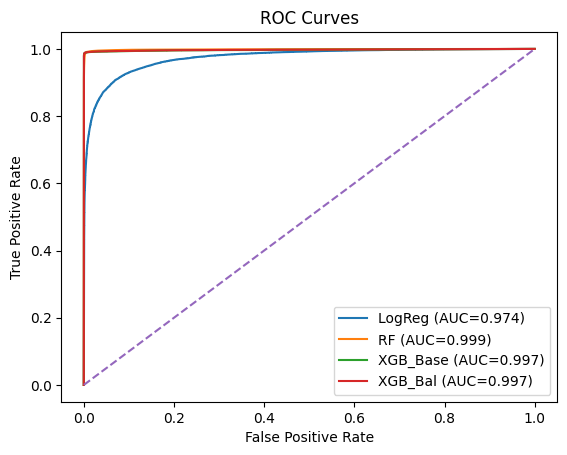

In [16]:
def plot_roc_curves(y_true, proba_dict):
    plt.figure()
    for name, proba in proba_dict.items():
        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
    plt.plot([0,1], [0,1], "--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

plot_roc_curves(
    y_test,
    {
        "LogReg": y_proba_log,
        "RF": y_proba_rf,
        "XGB_Base": y_proba_xgb,
        "XGB_Bal": y_proba_xgb_bal
    }
)

ANALISIS KESALAHAN (FALSE POSITIIVE & FALSE NEGATIVE)

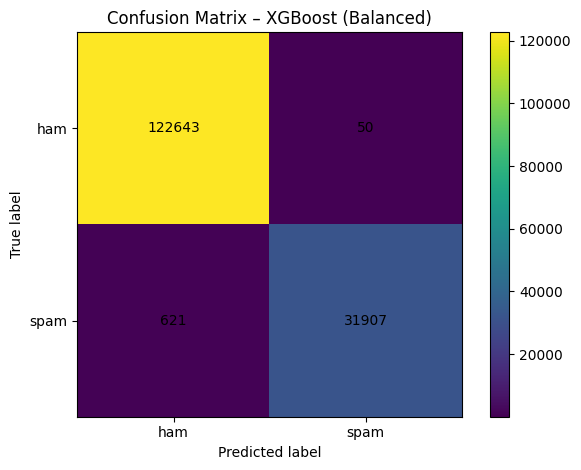

array([[122643,     50],
       [   621,  31907]])

In [17]:
# CONFUSION MATRIX MODEL FINAL: XGBOOST BALANCED

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix untuk XGBoost Balanced
cm = confusion_matrix(y_test, y_pred_xgb_bal)

plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix – XGBoost (Balanced)")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["ham", "spam"])
plt.yticks(tick_marks, ["ham", "spam"])
plt.xlabel("Predicted label")
plt.ylabel("True label")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.tight_layout()
plt.show()

cm

In [18]:
# ANALISIS FALSE POSITIVE & FALSE NEGATIVE

# Bangun kembali dataframe test (kalau belum)
test_df = df.loc[y_test.index, ["from_", "subject", "body", "label"]].copy()
test_df["pred_label"] = y_pred_xgb_bal
test_df["pred_proba"] = y_proba_xgb_bal

# False Positive: sebenarnya ham (0), diprediksi spam (1)
fp = test_df[(test_df["label"] == 0) & (test_df["pred_label"] == 1)].copy()

# False Negative: sebenarnya spam (1), diprediksi ham (0)
fn = test_df[(test_df["label"] == 1) & (test_df["pred_label"] == 0)].copy()

print("Jumlah False Positive  (ham → spam):", len(fp))
print("Jumlah False Negative (spam → ham):", len(fn))

print("\nContoh 5 False Positive:")
display(fp[["from_", "subject", "body", "pred_proba"]].head(5))

print("\nContoh 5 False Negative:")
display(fn[["from_", "subject", "body", "pred_proba"]].head(5))

Jumlah False Positive  (ham → spam): 50
Jumlah False Negative (spam → ham): 621

Contoh 5 False Positive:


,from_,subject,body,pred_proba
400744,dennis.alters@enron.com,FW: Station 4 overhauls,"Looks like some good news. \n\n -----Original Message-----\nFrom: \tMaestas, Gary \nSent:\tWednesday, January 09, 2002 7:09 AM\nTo:\tGottsponer, Morgan; Alters, Dennis\nCc:\tPribble, Dan; Keller,...",0.5653
402009,darrell.schoolcraft@enron.com,FW: tw imbalances,"-----Original Message-----\nFrom: \tHanagriff, Richard \nSent:\tMonday, January 28, 2002 9:28 PM\nTo:\tSchoolcraft, Darrell; Lokay, Michelle; McConnell, Mark; Lindberg, Lorraine; Y'barbo, Paul; W...",0.5408
495096,ben.asante@enron.com,RE: San Juan Lateral Eff.,The estimated throughput affected (at the pig speed of 5-7 mph) was about 600mmcfd. The run time was 18 hrs for the DRA.\nBut we will monitor the efficiencies for two weeks after the pigging befor...,0.6666
495075,jeanne.licciardo@enron.com,RE: February -1 Capacity Analysis System ( CAS) meeting,Attached are the minutes from the meeting and also the Production log. Please review and let me know if I have stated anything incorrectly. I will be out of the office starting on 2/5 thru 2/8. Wh...,0.5308
205130,vkaminski@aol.com,Fwd: Successful purchase of NBER Paper,"Return-Path: <Gregory_Gordon@ssrn.com>\nReceived: from rly-xd05.mx.aol.com (rly-xd05.mail.aol.com [172.20.105.170]) \nby air-xd02.mail.aol.com (v77_r1.36) with ESMTP; Sat, 28 Apr 2001 18:55:21 \n...",0.6099



Contoh 5 False Negative:


,from_,subject,body,pred_proba
341363,scott.neal@enron.com,,"---------------------- Forwarded by Scott Neal/HOU/ECT on 04/25/2001 08:48 AM \n---------------------------\n\n\n""scott neal"" <sneal12@mindspring.com> on 04/24/2001 09:10:17 PM\nTo: <Scott.Neal@en...",0.4321
212323,rebrooks@earthlink.net,GPCM News: 11/26/01: AGA Storage Report: Arctic Drilling Affected,From http://www.enerfax.com :\n \nAGA Natural Gas Storage Report\n \n Week Prev \n Ending Prev Prev Year \n|...,0.4705
446841,matt.smith@enron.com,RE: scuba dooooooooooooo,"Well March probably isn't great for me anyway...going to NYC 8-11, and my \nbrother's coming for a week. So, I guess just keep me posted. I took a week \noff and went to South Padre island so it...",0.0741
40006,larry.campbell@enron.com,,http://quotes.freerealtime.com/rt/frt/news?symbol=PMCS&art=C2000090100245b1087,0.1975
94747,newsletter@rigzone.com,RIGZONE Industry News,"RIGZONE DAILY NEWS -- TUESDAY, MARCH 19, 2002\n------------------------------------------------------------\nDaily News from the worldwide upstream oil & gas industry\n to view the complete vers...",0.3710


EXPLAINABILITY & FEATURE IMPORTANCE (MODEL FINAL)

In [19]:
# FEATURE IMPORTANCE DARI XGBOOST BALANCED

importances = xgb_balanced.feature_importances_
feature_names = list(tfidf.get_feature_names_out()) + ["subject_len", "body_len", "num_urls", "is_internal_sender"]

fi_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False)

top20 = fi_df.head(20)
top20

,feature,importance
21631,free,0.0771
33750,offer,0.0575
11408,click,0.0441
20580,feel free,0.0436
6013,affiliates,0.0364
33767,offered,0.0224
33771,offering,0.0181
20577,feel,0.0147
47381,unsubscribe,0.0135
49182,winfree,0.0134


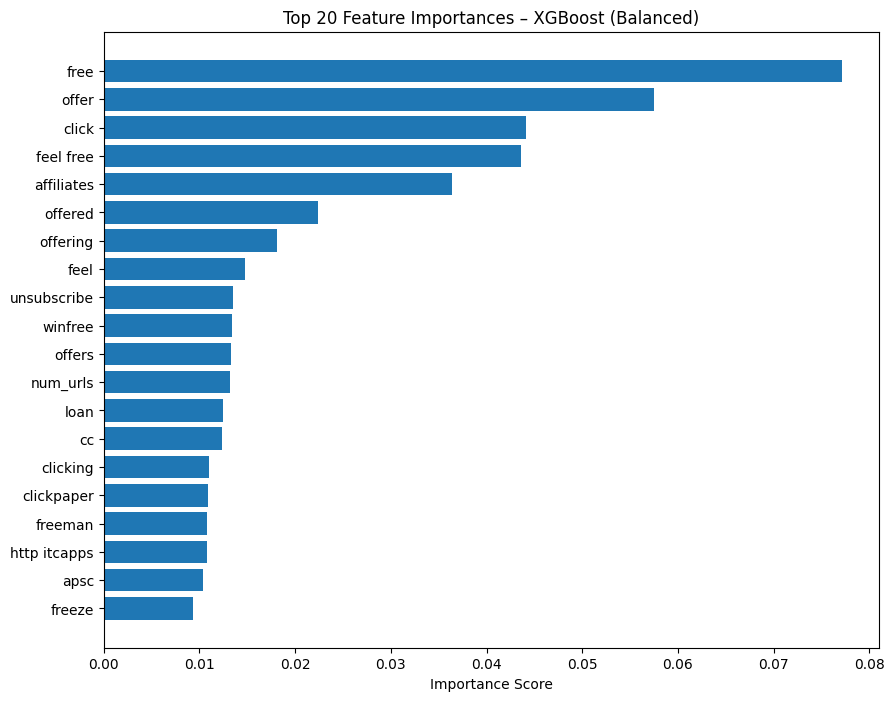

In [20]:
# VISUALISASI FEATURE IMPORTANCE

plt.figure(figsize=(10, 8))
plt.barh(top20["feature"], top20["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Feature Importances – XGBoost (Balanced)")
plt.xlabel("Importance Score")
plt.show()

MITIGASI & DEFENDER ACTION

In [21]:
# STRATEGI PENANGANAN EMAIL BERBASIS RISIKO

# Pastikan kita punya test_df berbasis y_test
test_df = df.loc[y_test.index, ["from_", "subject", "body", "label"]].copy()
test_df["pred_proba"] = y_proba_xgb_bal
test_df["pred_label"] = y_pred_xgb_bal

# Ambil domain
test_df["domain"] = test_df["from_"].str.extract(r'@(.+)$')

# 1. Risk level berdasarkan probabilitas spam
def get_risk_level(p):
    if p > 0.90:
        return "HIGH"
    elif p >= 0.70:
        return "MEDIUM"
    else:
        return "LOW"

test_df["risk_level"] = test_df["pred_proba"].apply(get_risk_level)

# 2. Flag internal / external
def is_internal(domain):
    if isinstance(domain, str):
        return "enron.com" in domain.lower()
    return False

test_df["is_internal"] = test_df["domain"].apply(is_internal)

# 3. Mapping risk_level + internal/external -> ACTION
def choose_action(row):
    if row["risk_level"] == "HIGH":
        if row["is_internal"]:
            # internal tetapi tinggi → jangan langsung blok, kirim ke manusia
            return "ALERT_REVIEW"
        else:
            return "QUARANTINE"
    elif row["risk_level"] == "MEDIUM":
        return "ALERT_REVIEW"
    else:
        return "ALLOW"

test_df["action"] = test_df.apply(choose_action, axis=1)

# 4. Ringkasan jumlah per action
action_counts = test_df["action"].value_counts()
action_props = test_df["action"].value_counts(normalize=True).rename("proportion")

print("Summary jumlah email per action:")
print(action_counts)
print("\nProporsi per action:")
print(action_props)


Summary jumlah email per action:
action
ALLOW           123581
ALERT_REVIEW     19966
QUARANTINE       11674
Name: count, dtype: int64

Proporsi per action:
action
ALLOW          0.7962
ALERT_REVIEW   0.1286
QUARANTINE     0.0752
Name: proportion, dtype: float64


In [22]:
# TABEL QUARANTINE, ALERT_REVIEW, ALLOW

quarantine_df = test_df[test_df["action"] == "QUARANTINE"].copy()
alert_df      = test_df[test_df["action"] == "ALERT_REVIEW"].copy()
allow_df      = test_df[test_df["action"] == "ALLOW"].copy()

print("Jumlah email QUARANTINE :", len(quarantine_df))
print("Jumlah email ALERT_REVIEW:", len(alert_df))
print("Jumlah email ALLOW       :", len(allow_df))

print("\nContoh email QUARANTINE:")
display(quarantine_df[["from_", "domain", "subject", "pred_proba"]].head(10))

print("\nContoh email ALERT_REVIEW (terutama internal):")
display(alert_df[["from_", "domain", "subject", "pred_proba", "is_internal"]].head(10))

Jumlah email QUARANTINE : 11674
Jumlah email ALERT_REVIEW: 19966
Jumlah email ALLOW       : 123581

Contoh email QUARANTINE:


,from_,domain,subject,pred_proba
211913,news-from-iir@iirny.rs88.net,iirny.rs88.net,Don't miss IIR's Private Placements Summit!,0.9999
345185,streamer@datek.m0.net,datek.m0.net,READY TO TRADE OPTIONS?,0.9999
477710,bhutt@ankarcapital.com,ankarcapital.com,Re: Viva VI or are they?,0.9890
15684,ameritrade_011407@ameritrade.customer-email.com,ameritrade.customer-email.com,Great News from Ameritrade!,1.0000
16071,texas@georgewbush.com,georgewbush.com,Calling All Texas e-Rangers!,0.9819
142697,soblander@carrfut.com,carrfut.com,daily distillate and unleaded charts as attachments 5/7,0.9999
339476,preferredreader@waldenbooks.m0.net,waldenbooks.m0.net,Special Preferred Reader Savings Offer,1.0000
411320,craig_vinson@cmicro.com,cmicro.com,RE: My love.,0.9987
137833,starwood@spg.0mm.com,spg.0mm.com,Earn Starpoints on the Double,1.0000
13540,gift@amazon.com,amazon.com,Save Big at Our Clearance Event,1.0000



Contoh email ALERT_REVIEW (terutama internal):


,from_,domain,subject,pred_proba,is_internal
481656,carol.clair@enron.com,enron.com,Documents,0.9970,True
86020,eileen.ogrady@dowjones.com,dowjones.com,FYI: The Ercot Story from 5/7 WSJ,0.8994,False
2353,k..allen@enron.com,enron.com,RE: try this one for starters,0.9261,True
172341,stanley.horton@enron.com,enron.com,Re: VP Candidate Greg Shea,0.9960,True
203317,vince.kaminski@enron.com,enron.com,"CERA Multimedia Presentation: December 8, 1999",0.9962,True
117602,dale.neuner@enron.com,enron.com,Re: TFX Agreement,0.9937,True
172786,john.dushinske@enron.com,enron.com,FW: Thanksgiving Holiday,0.9031,True
233624,mark.palmer@enron.com,enron.com,Elektro,0.9998,True
416230,sara.shackleton@enron.com,enron.com,Empresa Distribuidora de Energia Sur,0.9927,True
324276,karen.buckley@enron.com,enron.com,ENA Trading Track,0.9273,True


In [23]:
# BLOCKLIST DOMAIN DARI QUARANTINE EXTERNAL

external_quarantine_df = quarantine_df[~quarantine_df["is_internal"]].copy()

blocklist_domains = (
    external_quarantine_df["domain"]
    .dropna()
    .value_counts()
    .head(20)
)

print("Top 20 external domains yang di-quarantine (candidate blocklist):")
print(blocklist_domains)

Top 20 external domains yang di-quarantine (candidate blocklist):
domain
hotmail.com                    652
nymex.com                      348
carrfut.com                    309
ccomad3.uu.commissioner.com    283
aol.com                        188
yahoo.com                      179
intcx.com                      147
williams.com                   138
concureworkplace.com           128
haas.berkeley.edu              127
amazon.com                     126
scientech.com                  115
motleyfool.com                 109
worldnet.att.net               104
nytimes.com                     96
cheatsheets.net                 93
schwab.com                      82
msn.com                         80
reply.pm0.net                   79
wordsmith.org                   75
Name: count, dtype: int64


MENYIMPAN MODEL & VECTORIZER

In [24]:
# SIMPAN MODEL & VECTORIZER UNTUK DEPLOYMENT

joblib.dump(xgb_balanced, "model_xgb_balanced.pkl")
joblib.dump(tfidf, "tfidf_vectorizer.pkl")

print("Model dan TF-IDF berhasil disimpan sebagai:")
print("- model_xgb_balanced.pkl")
print("- tfidf_vectorizer.pkl")

Model dan TF-IDF berhasil disimpan sebagai:
- model_xgb_balanced.pkl
- tfidf_vectorizer.pkl
